# Welcome to the MESSAGEix framework

### *Integrated Assessment Modeling for the 21st Century*

Please refer to the [user guidelines](https://github.com/iiasa/message_ix/blob/master/NOTICE.rst)
for additional information on using *MESSAGEix*, including the recommended citation and how to name new models.

This tutorial is based on a presentation by Matthew Gidden ([@gidden](https://github.com/gidden))
for a summer school at the the **Centre National de la Recherche Scientifique (CNRS)**
on *Integrated Assessment Modeling* in June 2018.

## Scope of this tutorial: Building a Simple Energy Model

The goal of this tutorial is to build a simple energy model using *MESSAGEix* with minimal features that can be expanded in future tutorials.  

We will build the model component by component, focusing on both the **how** (code implementation) and **why** (mathematical formulation).

## Online documentation

The full framework documentation is available at [https://messageix.iiasa.ac.at](https://messageix.iiasa.ac.at)
    
<img src='_static/doc_page.png'>

## Simple installation

When working with Python, you can easily install `MESSAGEix` yourself and get all the tutorials:

```shell
$ conda install -c conda-forge message-ix # install the MESSAGEix package and all dependencies

$ messageix-dl # download all tutorials to your current directory
```

## A stylized reference energy system model for Westeros

This tutorial is based on the country of Westeros from the TV show "Game of Thrones".

<table align='center'><tr><td><img src='_static/westeros.jpg' width='150'></td><td><img src='_static/base_res.png'></td></tr></table>

## MESSAGEix: the mathematical paradigm

At its core, *MESSAGEix* is an optimization problem:

> $\min \quad ~c^T \cdot x$  
> $~s.t. \quad A \cdot x \leq b$

More explicitly, the model...
- optimizes an **objective function**, nominally minimizing total **system costs**
- under a system of **constraints** equations (inequalities or equality conditions)

The mathematical implementation includes a number of features that make it particularly geared towards the modelling of *energy-water-land systems* in the context of *climate change mitigation and sustainable development*.

Throughout this document, the mathematical formulation follows the convention that
- decision **VARIABLES** ($x$) are capitalized
- **parameters** ($A$, $b$) are lower case

## MESSAGEix: connected to the *ix modeling platform*

The *modeling platform for integrated and cross-cutting analysis* (ixmp) provides a powerful framework for working with scenarios, including a database infrastucture for data version control and interfaces to scientific programming languages.

<img src='_static/message_ixmp.png' width='700'>

## Ready, steady, go!

First, we import all the packages we need.

In [1]:
import pandas as pd
import ixmp
import message_ix

from message_ix.utils import make_df

%matplotlib inline

The `Platform` is your connection to a database for storing model input data and scenario results.

In [2]:
mp = ixmp.Platform(dbtype='HSQLDB')

INFO:root:launching ixmp.Platform with local HSQLDB database at '/Users/BintangYuwono/.local/share/ixmp/localdbdefault'


Once connected, we create a new `Scenario` to build our model.

In [3]:
scenario = message_ix.Scenario(mp, model='Westeros Electrified', 
                               scenario='baseline', version='new')

## Model Structure

We start by defining basic characteristics of the model, including time, space, and the energy system structure.

The model horizon will span 3 decades. Let's assume that we're far in the future after the events of A Song of Ice and Fire (which occur ~300 years after Aegon the conqueror).

| Math Notation | Model Meaning                |
|---------------|------------------------------|
| $y \in Y^H$   | time periods in history      |
| $y \in Y^M$   | time periods in model horizon|

In [4]:
history = [690]
model_horizon = [700, 710, 720]
scenario.add_horizon({'year': history + model_horizon,  
                      'firstmodelyear': model_horizon[0]})

Our model will have a single `node`, i.e., its spatial dimension.


| Math Notation | Model Meaning|
|---------------|--------------|
| $n \in N$     | node         |

In [5]:
country = 'Westeros'
scenario.add_spatial_sets({'country': country})

And we fill in the energy system's `commodities`, `levels`, `technologies`, and `mode` (defining how certain technologies operate). 


| Math Notation | Model Meaning|
|---------------|--------------|
| $c \in C$     | commodity    |
| $l \in L$     | level        |
| $t \in T$     | technology   |
| $m \in M$     | mode         |

In [6]:
scenario.add_set("commodity", ["electricity", "light"])
scenario.add_set("level", ["secondary", "final", "useful"])
scenario.add_set("technology", ['coal_ppl', 'gas_ppl', 'wind_ppl', 'grid', 'bulb'])
scenario.add_set("mode", "standard")

## Supply and Demand (or Balancing Commodities)

The fundamental premise of the model is to satisfy demand for energy (services).
To first order, demand for services like electricity track with economic productivity (GDP).
We define a GDP profile similar to first-world GDP growth from [1900-1930](https://en.wikipedia.org/wiki/List_of_regions_by_past_GDP):

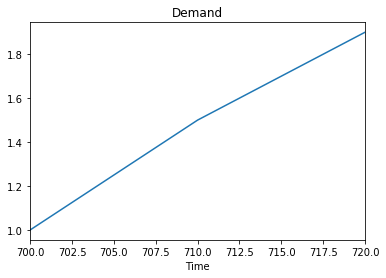

In [7]:
gdp_profile = pd.Series([1., 1.5, 1.9],
                        index=pd.Index(model_horizon, name='Time'))
gdp_profile.plot(title='Demand')

The `COMMODITY_BALANCE` equation ensures that `demand` for each `commodity` is met at each `level` in the energy system.

$\sum_{\substack{n^L,t,m \\ y^V \leq y}} \text{output}_{n^L,t,y^V,y,m,n,c,l} \cdot \text{ACT}_{n^L,t,y^V,y,m}$
$- \sum_{\substack{n^L,t,m, \\ y^V \leq y}} \text{input}_{n^L,t,y^V,y,m,n,c,l} \cdot \text{ACT}_{n^L,t,m,y}$  
$\geq \text{demand}_{n,c,l,y} \quad \forall \ l \in L$

While `demand` must be met, it can also be *exceeded* allowing the model to plan for future periods of demand for storable commodities.


First we establish demand. Let's assume

- 40 million people in [300 AC](https://atlasoficeandfireblog.wordpress.com/2016/03/06/the-population-of-the-seven-kingdoms/)
- similar population growth to Earth in the same time frame [(~factor of 12)](https://en.wikipedia.org/wiki/World_population_estimates)
- a per capita demand for electricity of 1000 kWh
- and 8760 hours in a year (of course!)

Then we can add the demand parameter

Note present day: [~17000 GWh in Austria](http://www.iea.org/statistics/statisticssearch/report/?country=AUSTRIA&product=electricityandheat&year=2015) with population [~9M](http://www.austria.org/population/) which is ~1890 kWh per capita

In [8]:
demand_per_year = 40 * 12 * 1000 / 8760
light_demand = pd.DataFrame({
        'node': country,
        'commodity': 'light',
        'level': 'useful',
        'year': model_horizon,
        'time': 'year',
        'value': (100 * gdp_profile).round(),
        'unit': 'GWa',
    })

`light_demand` illustrates the data format for MESSAGEix parameters. It is a `pandas.DataFrame` containing three types of information in a specific format:

- A "value" column containing the numerical values for this parameter.
- A "unit" column.
- Other columns ("node", "commodity", "level", "time") that indicate the key to which each value applies.

In [9]:
light_demand

,node,commodity,level,year,time,value,unit
Time,,,,,,,
700,Westeros,light,useful,700,year,100.0,GWa
710,Westeros,light,useful,710,year,150.0,GWa
720,Westeros,light,useful,720,year,190.0,GWa


In [10]:
scenario.add_par("demand", light_demand)

In order to add values for the reference energy system, we define some common keys.

- **Input** quantities require `_origin` keys that specify where the inputs are *received from*.
- **Output** quantities require `_dest` keys that specify where the outputs are *transferred to*.

In [11]:
year_df = scenario.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']

base = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': '-',
}

base_input = make_df(base, node_origin=country, time_origin='year')
base_output = make_df(base, node_dest=country, time_dest='year')

Working backwards along the Reference Energy System, we can add connections for the `bulb`. A light bulb…

- receives *input* in the form of the "electricity" *commodity* at the "final [energy]" *level*, and
- *outputs* the commodity "light" at the "useful [energy]" level.

Because there are no other commodities or forms of useful energy in Westeros, we specify that 100% of the input and output are from/to these commodities/levels.

In [12]:
bulb_out = make_df(base_output, technology='bulb', commodity='light', 
                   level='useful', value=1.0)
scenario.add_par('output', bulb_out)

bulb_in = make_df(base_input, technology='bulb', commodity='electricity',  
                  level='final', value=1.0)
scenario.add_par('input', bulb_in)

Next, the electrical `grid`, which…

- receives electricity at the "secondary" energy level.
- also outputs electricity, but at the "final" energy level (to be used by the light bulb).

Because the grid has transmission losses, only 90% of the input electricity is available as output.

In [13]:
grid_efficiency = 0.9
grid_out = make_df(base_output, technology='grid', commodity='electricity', 
                   level='final', value=grid_efficiency)
scenario.add_par('output', grid_out)

grid_in = make_df(base_input, technology='grid', commodity='electricity',
                  level='secondary', value=1.0)
scenario.add_par('input', grid_in)

And finally, our power plants. The model does not include the fossil resources used as `input` for coal plants; however, costs of coal extraction are included in the parameter $variable\_cost$.

In [14]:
coal_out = make_df(base_output, technology='coal_ppl', commodity='electricity', 
                   level='secondary', value=1.)
scenario.add_par('output', coal_out)

gas_out = make_df(base_output, technology='gas_ppl', commodity='electricity', 
                   level='secondary', value=1.)
scenario.add_par('output', gas_out)

wind_out = make_df(base_output, technology='wind_ppl', commodity='electricity', 
                   level='secondary', value=1.)
scenario.add_par('output', wind_out)

## Operational Constraints and Parameters

The model has a number of "reality" constraints, which relate built *capacity* (`CAP`) to available power, or the *activity* (`ACT`) of that technology.

The **capacity constraint** limits the total time a each technology can operate.

$$\sum_{m} \text{ACT}_{n,t,y^V,y,m,h}
    \leq \text{duration_time}_{h} \cdot \text{capacity_factor}_{n,t,y^V,y,h} \cdot \text{CAP}_{n,t,y^V,y}
    \quad t \ \in \ T^{INV}$$


This requires us to provide the `capacity_factor` for each technology. Here, we call `make_df()` and `add_par()` in a loop to execute similar code for three technologies:

In [15]:
base_capacity_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'time': 'year',
    'unit': '-',
}

In [16]:
capacity_factor = {
    'coal_ppl': 0.9,
    'gas_ppl': 0.6,
    'wind_ppl': 0.25,
    'bulb': 1, 
}

for tec, val in capacity_factor.items():
    df = make_df(base_capacity_factor, technology=tec, value=val)
    scenario.add_par('capacity_factor', df)

The model can further be provided `technical_lifetime`s in order to properly manage deployed capacity and related costs via the **capacity maintenance** constraint:

$\text{CAP}_{n,t,y^V,y} \leq \text{remaining_capacity}_{n,t,y^V,y} \cdot \text{value} \quad \forall \quad t \in T^{INV}$

where `value` can take different forms depending on what time period is considered:

| Value                               | Condition                                           |
|-------------------------------------|-----------------------------------------------------|
| $\Delta_y \text{historical_new_capacity}_{n,t,y^V}$ | $y$ is first model period           |
| $\Delta_y \text{CAP_NEW}_{n,t,y^V}$ | $y = y^V$                                           |
| $\text{CAP}_{n,t,y^V,y-1}$          | $0 < y - y^V < \text{technical_lifetime}_{n,t,y^V}$ |


In [17]:
base_technical_lifetime = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'y',
}

In [18]:
lifetime = {
    'coal_ppl': 25, # 500MWe Superctirical Pulverized Coal, https://iea-etsap.org/index.php/energy-technology-data
    'gas_ppl': 25, # 430MWe Cobined-Cycle Gas Turbine
    'wind_ppl': 20, # 2MWe Large Wind Turbine, On-shore
    'bulb': 1,
}

for tec, val in lifetime.items():
    df = make_df(base_technical_lifetime, technology=tec, value=val)
    scenario.add_par('technical_lifetime', df)

## Technological Diffusion and Contraction

We know from historical precedent that energy systems can not be transformed instantaneously. Therefore, we use a family of constraints on activity and capacity.

$\sum_{y^V \leq y,m} \text{ACT}_{n,t,y^V,y,m,h} \leq$  
$\text{initial_activity_up}_{n,t,y,h}
        \cdot \frac{ \Big( 1 + growth\_activity\_up_{n,t,y,h} \Big)^{|y|} - 1 }
                   { growth\_activity\_up_{n,t,y,h} }+ \Big( 1 + growth\_activity\_up_{n,t,y,h} \Big)^{|y|} \cdot \Big( \sum_{y^V \leq y-1,m} ACT_{n,t,y^V,y-1,m,h} + \sum_{m} historical\_activity_{n,t,y-1,m,h}\Big)$  

This example limits the ability for technologies to **grow**. To do so, we  need to provide `growth_activity_up` values for each technology that we want to model as being diffusion constrained. Here, we set this constraint at 10% per year.

In [19]:
base_growth = {
    'node_loc': country,
    'year_act': model_horizon,
    'time': 'year',
    'unit': '-',
}

In [20]:
growth_technologies = [
    "coal_ppl",
    "gas_ppl",
    "wind_ppl",
]

for tec in growth_technologies:
    df = make_df(base_growth, technology=tec, value=0.1) 
    scenario.add_par('growth_activity_up', df)

## Defining an Energy Mix

To model the transition of an energy system, one must start with the existing system which are defined by the parameters `historical_activity` and `historical_capacity`. These parameters define the energy mix before the model horizon.  

We begin by defining a few key values:

- how much useful energy was needed
- how much final energy was generated
- and the mix for different technologies

In [21]:
historic_demand = 0.85 * demand_per_year
historic_generation = historic_demand / grid_efficiency
coal_fraction = 0.8
gas_fraction = 0.2

In [22]:
base_capacity = {
    'node_loc': country,
    'year_vtg': history,
    'unit': 'GWa',
}

base_activity = {
    'node_loc': country,
    'year_act': history,
    'mode': 'standard',
    'time': 'year',
    'unit': 'GWa',
}

Then, we can define the **activity** and **capacity** in the historic period

In [23]:
old_activity = {
    'coal_ppl': coal_fraction * historic_generation,
    'gas_ppl': gas_fraction * historic_generation,
    'wind_ppl': (1 - coal_fraction - gas_fraction) * historic_generation,
}

for tec, val in old_activity.items():
    df = make_df(base_activity, technology=tec, value=val)
    scenario.add_par('historical_activity', df)

In [24]:
act_to_cap = {
    'coal_ppl': 1 / 10 / capacity_factor['coal_ppl'] / 2,
    'gas_ppl': 1 / 10 / capacity_factor['gas_ppl'] / 2,
    'wind_ppl': 1 / 10 / capacity_factor['wind_ppl'] / 2,
}

for tec in act_to_cap:
    value = old_activity[tec] * act_to_cap[tec]
    df = make_df(base_capacity, technology=tec, value=value)
    scenario.add_par('historical_new_capacity', df)

## Objective Function

The objective function drives the purpose of the optimization. Do we wish to seek maximum utility of the social planner, minimize carbon emissions, or something else? Classical IAMs seek to minimize total discounted system cost over space and time. 

$$\min \sum_{n,y \in Y^{M}} \text{interestrate}_{y} \cdot \text{COST_NODAL}_{n,y}$$


First, let's add the interest rate parameter.

In [25]:
rate = [0.05] * len(model_horizon)
unit = ['-'] * len(model_horizon)
scenario.add_par("interestrate", key=model_horizon, val=rate, unit=unit)

`COST_NODAL` is comprised of a variety of costs related to the use of different technologies.

### Investment Costs

Capital, or investment, costs are invoked whenever a new plant or unit is built

$$\text{inv_cost}_{n,t,y} \cdot \text{construction_time_factor}_{n,t,y} \cdot \text{CAP_NEW}_{n,t,y}$$

In [26]:
base_inv_cost = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'USD/GWa',
}

In [27]:
# in $ / kW
costs = {
    'coal_ppl': 1500, # 500MWe Superctirical Pulverized Coal, https://iea-etsap.org/index.php/energy-technology-data
    'gas_ppl': 1250, # 430MWe Cobined-Cycle Gas Turbine
    'wind_ppl': 1780, # 2MWe Large Wind Turbine, On-shore
    'bulb': 5,
}

for tec, val in costs.items():
    df = make_df(base_inv_cost, technology=tec, value=val)
    scenario.add_par('inv_cost', df)

### Fixed O&M Costs

Fixed cost are only relevant as long as the capacity is active. This formulation allows to include the potential cost savings from early retirement of installed capacity.

$$\sum_{y^V \leq y} \text{fix_cost}_{n,t,y^V,y} \cdot \text{CAP}_{n,t,y^V,y}$$

In [28]:
base_fix_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'unit': 'USD/GWa',
}

In [29]:
# in $ / kW
costs = {
    'coal_ppl': 75,
    'gas_ppl': 44,
    'wind_ppl': 10,
}

for tec, val in costs.items():
    df = make_df(base_fix_cost, technology=tec, value=val)
    scenario.add_par('fix_cost', df)

### Variable O&M Costs

Variable Operation and Maintence costs are associated with the costs of actively running the plant. Thus, they are not applied if a plant is on standby (i.e., constructed, but not currently in use).

$$\sum_{\substack{y^V \leq y \\ m,h}} \text{var_cost}_{n,t,y^V,y,m,h} \cdot \text{ACT}_{n,t,y^V,y,m,h} $$

In [30]:
base_var_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': 'USD/GWa',
}

In [31]:
# in $ / MWh
costs = {
    'coal_ppl': 30,
    'gas_ppl': 40,
    'wind_ppl': 0.02,
    'grid': 50,
}

for tec, val in costs.items():
    df = make_df(base_var_cost, technology=tec, value=val)
    scenario.add_par('var_cost', df)

A full model will also have costs associated with

- costs associated with technologies (investment, fixed, variable costs)
- resource extraction: $\sum_{c,g} \ resource\_cost_{n,c,g,y} \cdot EXT_{n,c,g,y} $
- emissions
- land use (emulator): $\sum_{s} land\_cost_{n,s,y} \cdot LAND_{n,s,y}$

## Time to Solve the Model

First, we *commit* the model structure and input data (sets and parameters).
In the `ixmp` backend, this creates a new model version in the database, which is assigned a number automatically:

In [32]:
ixmp.logger().info('version number prior to commit: {}'.format(scenario.version))

scenario.commit(comment='basic model of Westerosi electrification')

ixmp.logger().info('version number prior committing to the database: {}'.format(scenario.version))

INFO:root:version number prior to commit: 0
INFO:root:version number prior committing to the database: 27


An `ixmp` database can contain many scenarios, and possibly multiple versions of the same model and scenario name.
These are distinguished by unique version numbers.

To make it easier to retrieve the "correct" version (e.g., the latest one), you can set a specific scenario as the default version to use if the "Westeros Electrified" model is loaded from the `ixmp` database.

In [33]:
scenario.set_as_default()

In [34]:
scenario.solve()

In [35]:
scenario.var('OBJ')['lvl']

359840.34375

## Plotting Results

We make use of some custom code; see `tools.py` in the tutorial directory.

In [36]:
from tools import Plots
p = Plots(scenario, country, firstyear=model_horizon[0])

### Activity

How much energy is generated in each time period from the different potential sources?

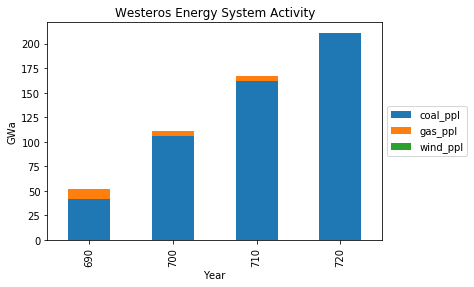

In [37]:
p.plot_activity(baseyear=True, subset=['coal_ppl', 'gas_ppl', 'wind_ppl'])

### Capacity

Given how many new plants are built, how many are actually used?

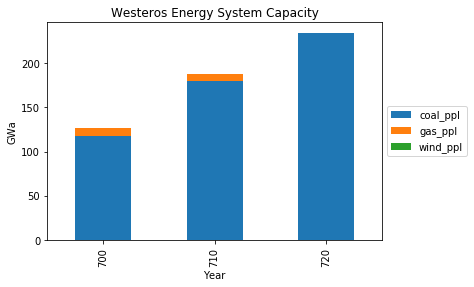

In [38]:
p.plot_capacity(baseyear=True, subset=['coal_ppl', 'gas_ppl', 'wind_ppl'])

### Electricity Price

And how much does the electricity cost? These prices are taken from the **dual variables** of the solution and are given the name **shadow prices**. They reflect the marginal price of electricity, taken from the most expensive producer.  

Note that the price drop when the most expensive technology is no longer in the system.

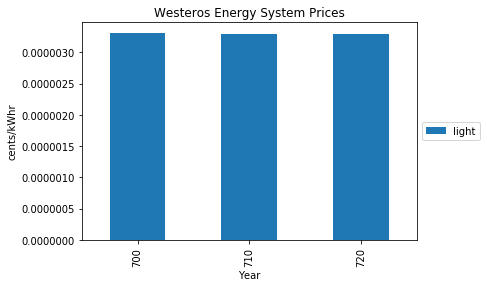

In [39]:
p.plot_prices(subset=['light'], baseyear=True)

## Close the connection to the database

When working with local HSQLDB database instances, you cannot connect to one database from multipe Jupyter notebooks (or processes) at the same time.

If you want to easily switch between notebooks with connections to the same `ixmp` database, you need to close the connection in one notebook before initializing the platform using `ixmp.Platform(dbtype='HSQLDB')` in another notebook.

After having closed the database connection, you can reopen it using
```
mp.open_db()
```

In [40]:
mp.close_db()

## Congratulations! 

You have built and run your very first MESSAGEix model. Welcome to the community!

The next tutorials will introduce you to other features of the framework, including energy system constraints, emissions taxes, and other policy options.

Check us out on Github https://github.com/iiasa/message_ix  
and get in touch with us online https://groups.google.com/forum/message-ix ...